# CIFAR10分类模型研究
**by leichen**

## 加载库

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter  
import torch.nn.functional as F
from torchvision.transforms import ToPILImage
import torch.backends.cudnn as cudnn
import datetime
import argparse

## 数据读取与增强

In [2]:
agg_transform = transforms.Compose(
    [
     #transforms.RandomCrop(32, padding=4),#使用数据增强 
     #transforms.RandomResizedCrop(size=(32,32), scale=(0.6, 0.9),ratio=(0.5,2)),
     #transforms.RandomHorizontalFlip(), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 500

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=agg_transform)  #不使用数据增强transform = transform1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 数据展示

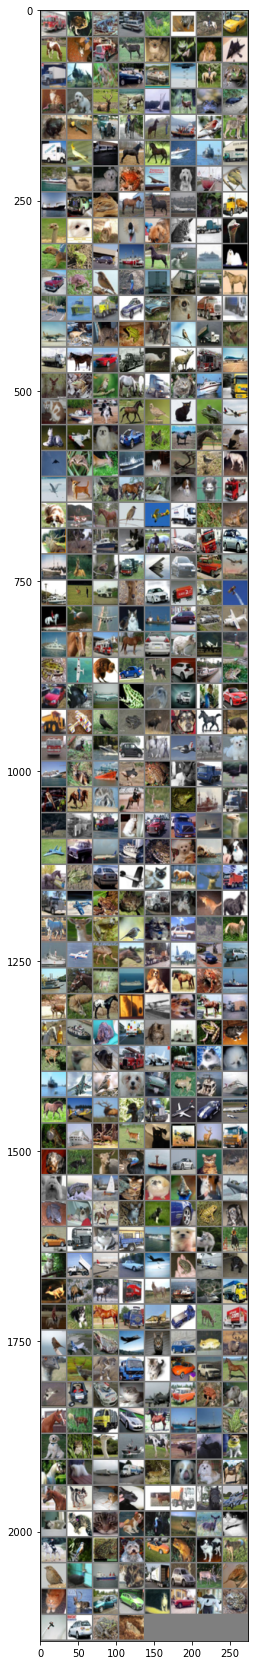

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(30,30))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Alexnet模型

In [7]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.cnn = nn.Sequential(
            # 卷积层1，3通道输入，96个卷积核，核大小7*7，步长2，填充2
            # 经过该层图像大小变为32-7+2*2 / 2 +1，15*15
            # 经3*3最大池化，2步长，图像变为15-3 / 2 + 1， 7*7
            nn.Conv2d(3, 96, 7, 2, 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 0),

            # 卷积层2，96输入通道，256个卷积核，核大小5*5，步长1，填充2
            # 经过该层图像变为7-5+2*2 / 1 + 1，7*7
            # 经3*3最大池化，2步长，图像变为7-3 / 2 + 1， 3*3
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 0),

            # 卷积层3，256输入通道，384个卷积核，核大小3*3，步长1，填充1
            # 经过该层图像变为3-3+2*1 / 1 + 1，3*3
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(inplace=True),

            # 卷积层3，384输入通道，384个卷积核，核大小3*3，步长1，填充1
            # 经过该层图像变为3-3+2*1 / 1 + 1，3*3
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(inplace=True),

            # 卷积层3，384输入通道，256个卷积核，核大小3*3，步长1，填充1
            # 经过该层图像变为3-3+2*1 / 1 + 1，3*3
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(inplace=True)
        )

        self.fc = nn.Sequential(
            # 256个feature，每个feature 3*3
            nn.Linear(256*3*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.cnn(x)

        # x.size()[0]: batch size
        x = x.view(x.size()[0], -1)
        x = self.fc(x)

        return x

## ResNet34

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()

        # 残差块的第一个卷积
        # 通道数变换in->out，每一层（除第一层外）的第一个block
        # 图片尺寸变换：stride=2时，w-3+2 / 2 + 1 = w/2，w/2 * w/2
        # stride=1时尺寸不变，w-3+2 / 1 + 1 = w
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # 残差块的第二个卷积
        # 通道数、图片尺寸均不变
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 残差块的shortcut
        # 如果残差块的输入输出通道数不同，则需要变换通道数及图片尺寸，以和residual部分相加
        # 输出：通道数*2 图片尺寸/2
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            # 通道数相同，无需做变换，在forward中identity = x
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet34(nn.Module):
    def __init__(self, block):
        super(ResNet34, self).__init__()

        # 初始卷积层核池化层
        self.first = nn.Sequential(
            # 卷基层1：7*7kernel，2stride，3padding，outmap：32-7+2*3 / 2 + 1，16*16
            nn.Conv2d(3, 64, 7, 2, 3),
            #nn.Conv2d(3, 64, 3, 1, 1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # 最大池化，3*3kernel，1stride（32的原始输入图片较小，不再缩小尺寸），1padding，
            # outmap：16-3+2*1 / 1 + 1，16*16
            nn.MaxPool2d(3, 1, 1)
        )

        # 第一层，通道数不变
        self.layer1 = self.make_layer(block, 64, 64, 3, 1)

        # 第2、3、4层，通道数*2，图片尺寸/2
        self.layer2 = self.make_layer(block, 64, 128, 4, 2)  # 输出8*8
        self.layer3 = self.make_layer(block, 128, 256, 6, 2)  # 输出4*4
        self.layer4 = self.make_layer(block, 256, 512, 3, 2)  # 输出2*2
        self.avg_pool = nn.AvgPool2d(2)
        #self.avg_pool = nn.AvgPool2d(4)  # 输出512*1
        self.fc = nn.Linear(512, 10)

    def make_layer(self, block, in_channels, out_channels, block_num, stride):
        layers = []

        # 每一层的第一个block，通道数可能不同
        layers.append(block(in_channels, out_channels, stride))

        # 每一层的其他block，通道数不变，图片尺寸不变
        for i in range(block_num - 1):
            layers.append(block(out_channels, out_channels, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.first(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)

        # x.size()[0]: batch size
        x = x.view(x.size()[0], -1)
        x = self.fc(x)

        return x

**测试**

In [ ]:
def test(data,model):
    correct = 0
    total = 0
    total_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for batch in data:
            images, label = batch
            images = Variable(images).cuda()
            label = Variable(label).cuda()#与labels 变量区分
            # calculate outputs by running images through the network
            output = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            res = criterion(output, label)#与loss变量区分
            total_loss += res.item()
    acc = 100 * correct / total
    mean_loss = total_loss/len(data)
    return acc, mean_loss

## 实验

In [ ]:
net = AlexNet()#AlexNet 模型
#net = ResNet34(ResBlock) #Resnet34
net.cuda()
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters(), lr=0.001)
writer = SummaryWriter('log')
lr = 0.001
for epoch in range(20):  # loop over the dataset multiple times
    #if epoch%8 ==0:
        #lr = lr/2
    optimizer = optim.Adam(net.parameters(), lr=lr)
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = Variable(inputs).cuda()
        labels = Variable(labels).cuda()
        # zero the parameter gradients
        optimizer.zero_grad()#归零梯度

        # forward + backward + optimize
        outputs = net(inputs) #前向
        loss = criterion(outputs, labels)#损失
        loss.backward()#反向传播
        optimizer.step()
    train_acc, train_loss = test(trainloader, net)
    test_acc, test_loss = test(testloader, net)
    writer.add_scalar('Train/Loss', train_loss, epoch+1)
    writer.add_scalar('Train/Accu', train_acc, epoch+1)
    writer.add_scalar('test/Loss', test_loss, epoch+1)
    writer.add_scalar('test/Accu', test_acc, epoch+1)
    print(f'第{epoch+1}个epoch训练集的识别准确率为：{round(train_acc,2)}% ,损失为：{round(train_loss,3)}' )
    print(f'第{epoch+1}个epoch测试集的识别准确率为：{round(test_acc,2)}% ,损失为：{round(test_loss,3)}' )
writer.close()
print('Finished Training')